# 3. Project 3: Other approaches - Summarized LeaveOneOut (s-LOO)

Project 3: Non-Parametric Methods
- Enrique Almazán Sánchez
- Judith Briz Galera

As the results obtained are too mediocre (shown in the previous document), we are going to try other approaches, in order to see if we can improve the performance of the models used, or the problem is related to the dataset itself.

In LeaveOneOut test, for each iteration, a single data point (observation) is selected as the test set, and the model is trained on the remaining data points. This process is repeated for each data point, resulting in as many iterations as there are data points in the dataset. 

It provides a comprehensive assessment of model performance as the model is trained and tested on each individual data point, being particularly useful for small datasets (as ours seen from the perspective of patients, having only 40), while computationally expensive for large datasets since it requires training the model numerous times.

**The s-LOO approach**. "The aim of summarizing the voice samples of subjects by making mean-based grouping is to decrease the effect of variations between different voice samples of a subject. These variations are originated from the fact that not all the voice samples of a PWP show the dysphonia indications. Thus, labeling all the voice samples of a PWP as positive and learning the model with this label vector misguide the classifier, which results in a weak prediction model."

(Sakar BE, Isenkul ME, Sakar CO, Sertbas A, Gurgen F, Delil S, Apaydin H, Kursun O. Collection and analysis of a Parkinson speech dataset with multiple types of sound recordings. IEEE J Biomed Health Inform. 2013 Jul;17(4):828-34. doi: 10.1109/JBHI.2013.2245674. PMID: 25055311.)


## Imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import utils as u

# Feature Selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# Preprocessing
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler

# Figures of merit
from sklearn.metrics import accuracy_score

# Models to be implemented
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    VotingClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [2]:
import warnings

# Desactivar todas las advertencias (no se recomienda a menos que sea necesario)
warnings.filterwarnings("ignore")

## 1. Dataset import

For this approach, we need the original dataset, as the previous preprocessed one is not valid due to the split technique followed.

In [3]:
# Download the dataset as a pandas DataFrame
df = pd.read_csv("train_data.txt", header=None)

# As the dataset comes without header, we add the different names of the columns
df.columns = [
    'Patient Identifier',
    'Jitter in %',
    'Absolute Jitter in microseconds',
    'Jitter as relative amplitude perturbation',
    'Jitter as 5-point period perturbation',
    'Absolute Jitter difference between Jitter Cycles',
    'Shimmer in %','Absolute Shimmer in decibels (dB)',
    'Shimmer as 3 point amplitude perturbation',
    'Shimmer as 5 point amplitude perturbation',
    'Shimmer as 11 point amplitude perturbation',
    'Shimmer as Average absolute difference between amplitude of shimmer cycles',
    'Autocorrelation between NHR and HNR',
    'Noise to Harmonic Ratio (NHR)',
    'Harmonic to Noise Ratio (HNR)',
    'Median Pitch','Mean Pitch',
    'Standard Deviation of Pitch',
    'Minimum Pitch','Maximum Pitch',
    'Number of Pulses','Number of Periods',
    'Mean Period',
    'Standard Deviation of Period',
    'Fraction of unvoiced frames',
    'Number of voice breaks','Degree of voice break',
    'UPDRS',
    'Status'
]

For this approach, the patients established by the 'Patient Identifier' are stored in a variable in order to divide them.

In [4]:
patients = df['Patient Identifier'].unique()

Now we group each of the speech recordings by 'Patient Indentifier', in order to try to summarize each patient in a unique example.

In [5]:
df = df.groupby('Patient Identifier').mean()

In [6]:
df

,Jitter in %,Absolute Jitter in microseconds,Jitter as relative amplitude perturbation,Jitter as 5-point period perturbation,Absolute Jitter difference between Jitter Cycles,Shimmer in %,Absolute Shimmer in decibels (dB),Shimmer as 3 point amplitude perturbation,Shimmer as 5 point amplitude perturbation,Shimmer as 11 point amplitude perturbation,...,Maximum Pitch,Number of Pulses,Number of Periods,Mean Period,Standard Deviation of Period,Fraction of unvoiced frames,Number of voice breaks,Degree of voice break,UPDRS,Status
Patient Identifier,,,,,,,,,,,,,,,,,,,,,
1,2.319462,0.000115,1.108269,1.262692,3.324808,10.548308,1.067231,4.189692,6.317538,11.896231,...,226.728654,171.500000,169.384615,0.005020,0.000427,17.318192,0.730769,6.825923,23.0,1.0
2,2.688038,0.000215,1.274769,1.453346,3.824231,12.371192,1.182192,5.537654,7.136808,12.699423,...,163.935231,121.346154,119.038462,0.008001,0.000629,9.720462,0.884615,5.673423,8.0,1.0
3,3.006423,0.000131,1.631077,1.689115,4.892885,17.155731,1.494769,8.115385,10.962200,15.306125,...,308.129154,105.769231,101.846154,0.004544,0.000763,35.108115,1.115385,13.966962,40.0,1.0
4,1.545038,0.000063,0.806769,0.828808,2.419923,10.647423,1.015308,5.114423,6.672269,9.102962,...,272.957500,173.230769,170.846154,0.004114,0.000283,11.514115,0.884615,10.894308,5.0,1.0
5,2.749600,0.000250,1.234960,1.275200,3.704840,14.945240,1.369040,7.246840,9.553240,15.491000,...,163.005480,55.884615,53.769231,0.009014,0.000966,23.878000,1.038462,11.456154,16.0,1.0
6,2.797154,0.000209,1.381615,1.534692,4.145192,14.133038,1.302077,5.587654,8.600538,17.095920,...,169.448808,115.769231,113.153846,0.007436,0.000602,17.221077,1.038462,8.463385,46.0,1.0
7,2.760500,0.000215,1.358231,1.417885,4.074846,12.418423,1.152538,5.290192,7.008000,13.010600,...,182.085846,60.346154,58.269231,0.007847,0.000804,26.624962,0.692308,8.661000,40.0,1.0
8,2.216308,0.000150,1.031192,1.055462,3.093538,11.972500,1.155462,5.377923,7.255808,10.381115,...,175.068000,91.615385,89.769231,0.006826,0.000637,28.967808,0.615385,8.711692,20.0,1.0
9,2.032962,0.000184,0.859885,1.039731,2.579500,11.910154,1.141462,5.188500,7.267577,10.558520,...,135.174808,67.961538,66.038462,0.009003,0.000630,19.168615,0.884615,10.464231,11.0,1.0


Ending with this section, we divide between dependent and independent variable.

In [7]:
# Dependent variable
X = df.drop(['Status', 'UPDRS'], axis=1)
# Independent variable
y = df['Status']

Even though the raw dataset is used, we are going to considered that it is already preprocessed, as we are going to considered that no outliers are found when summarizing the data with the mean of each speech recording of each patient.

## 2. Feature Selection

First of all, the column 'Patient Identifier' is eliminated, as it does not give any valuable information.

In [8]:
# Create and fit the classifier
clf = ExtraTreesClassifier(n_estimators=50, random_state=10)
clf = clf.fit(X, y)

# Create and fit SelectFromModel with feature names
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

# Get feature importances for all features
importances = dict(zip(X.columns, clf.feature_importances_))

And we show the results.

In [9]:
# Find the maximum width of the keys for formatting
max_key_width = max(map(len, importances.keys()))

for key, value in importances.items():
    print(f"{key.ljust(max_key_width)}  {round(value, 3)}")

Jitter in %                                                                 0.045
Absolute Jitter in microseconds                                             0.047
Jitter as relative amplitude perturbation                                   0.032
Jitter as 5-point period perturbation                                       0.032
Absolute Jitter difference between Jitter Cycles                            0.026
Shimmer in %                                                                0.029
Absolute Shimmer in decibels (dB)                                           0.027
Shimmer as 3 point amplitude perturbation                                   0.026
Shimmer as 5 point amplitude perturbation                                   0.05
Shimmer as 11 point amplitude perturbation                                  0.049
Shimmer as Average absolute difference between amplitude of shimmer cycles  0.037
Autocorrelation between NHR and HNR                                         0.028
Noise to Harmonic

The correlation matrix is shown in the first jupyter notebook, thus, we show the different groups of features which have high correletion between them.

In [10]:
# Creamos una lista con las columnas/características
columns = list(X.columns)

# Creamos un diccionario para almacenar los grupos de columnas altamente correlacionadas
correlation_groups = {}

# Iteramos sobre las columnas de la lista creada previamente
for column in columns:
    
    # Flag para indicar si la columna está asignada a un grupo existente
    assigned_to_group = False
    
    # Iteramos sobre los grupos existentes
    for group, group_columns in correlation_groups.items():
        
        # Calculamos la correlación promedio entre la columna actual y las columnas del grupo
        avg_correlation = sum(X[column].corr(X[col]) for col in group_columns) / len(group_columns)
        
        # Si la correlación promedio es mayor que un umbral, asignamos la columna al grupo
        if avg_correlation > 0.8 or avg_correlation < -0.75:
            correlation_groups[group].append(column)
            assigned_to_group = True
            break
    
    # Si la columna no se asigna a un grupo existente, creamos un nuevo grupo
    if not assigned_to_group:
        correlation_groups[column] = [column]

In [11]:
# Showing the resulting groups
for i, (group, group_columns) in enumerate(correlation_groups.items()):
    print(f"\n{i+1} Group {group}: {group_columns}")


1 Group Jitter in %: ['Jitter in %', 'Jitter as relative amplitude perturbation', 'Jitter as 5-point period perturbation', 'Absolute Jitter difference between Jitter Cycles', 'Shimmer as 11 point amplitude perturbation']

2 Group Absolute Jitter in microseconds: ['Absolute Jitter in microseconds']

3 Group Shimmer in %: ['Shimmer in %', 'Absolute Shimmer in decibels (dB)', 'Shimmer as 3 point amplitude perturbation', 'Shimmer as 5 point amplitude perturbation', 'Shimmer as Average absolute difference between amplitude of shimmer cycles', 'Autocorrelation between NHR and HNR']

4 Group Noise to Harmonic Ratio (NHR): ['Noise to Harmonic Ratio (NHR)', 'Harmonic to Noise Ratio (HNR)']

5 Group Median Pitch: ['Median Pitch', 'Mean Pitch', 'Minimum Pitch', 'Mean Period']

6 Group Standard Deviation of Pitch: ['Standard Deviation of Pitch', 'Maximum Pitch']

7 Group Number of Pulses: ['Number of Pulses', 'Number of Periods']

8 Group Standard Deviation of Period: ['Standard Deviation of Peri

Now we select one feature per correlation group, which is the one with more importance per group.

In [12]:
# Create a list to add the best features
best_features = []

# Iterating over the correlation_groups as a dictionary of groups of correlated features
# (the created in the previous example)
for group, group_columns in correlation_groups.items():
    # Find the feature with the highest importance in the current group
    best_features.append(max(group_columns, key=lambda x: importances[x]))

We show the selected features.

In [13]:
# Show the features selected
for i, feature in enumerate(best_features):
    print(f"Best feature for group {i+1}: {feature}")

Best feature for group 1: Shimmer as 11 point amplitude perturbation
Best feature for group 2: Absolute Jitter in microseconds
Best feature for group 3: Shimmer as 5 point amplitude perturbation
Best feature for group 4: Harmonic to Noise Ratio (HNR)
Best feature for group 5: Minimum Pitch
Best feature for group 6: Maximum Pitch
Best feature for group 7: Number of Pulses
Best feature for group 8: Number of voice breaks
Best feature for group 9: Fraction of unvoiced frames
Best feature for group 10: Degree of voice break


In [14]:
clf = clf.fit(X[best_features], y)

# Get feature importances for best features
importances = dict(zip(X[best_features].columns, clf.feature_importances_))

for key, value in importances.items():
    print(f"{key.ljust(max_key_width)}  {round(value, 3)}")

Shimmer as 11 point amplitude perturbation                                  0.12
Absolute Jitter in microseconds                                             0.091
Shimmer as 5 point amplitude perturbation                                   0.095
Harmonic to Noise Ratio (HNR)                                               0.078
Minimum Pitch                                                               0.072
Maximum Pitch                                                               0.07
Number of Pulses                                                            0.086
Number of voice breaks                                                      0.131
Fraction of unvoiced frames                                                 0.089
Degree of voice break                                                       0.168


For this approach, as was expected, we can find some differences among the most important features with respect the previous approaches. This is due to the summarized data we are using in this aproach.

## 3. Presentation of the methods

The methods presented below have already been explained in the 'README' document. Also, their hyperparamters have been established by basing in those obtained in the first document, using Gridsearch and a robust cross-validation approach, as well as using some try and error.

In [23]:
# List with the models to use
models = [
    ("KNN", KNeighborsClassifier(algorithm='auto', n_neighbors=3, p=1, weights='distance')),
    ("DTC", DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_leaf=5, min_samples_split=3, splitter='random')),
    ("RFC", RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=133)),
    ("GBT", GradientBoostingClassifier(learning_rate=1.0, max_depth=11, n_estimators=32)),
    ("MLP", MLPClassifier(activation='tanh', alpha=0.0001, hidden_layer_sizes=(50,))),
    ("SMV", SVC(kernel='linear', probability=True)),
]

## 4. Summarized LeaveOneOut (s-LOO)

Finally, we implement the s-LOO approach, by making mean-based grouping.

---KNN---
Average Accuracy Train: 1.0
Standard Deviation Train: 0.0
Average Accuracy Test: 0.475
Standard Deviation Test: 0.499




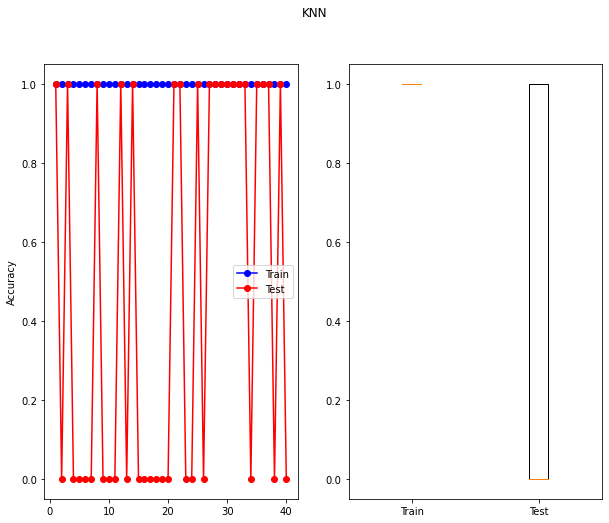

---DTC---
Average Accuracy Train: 0.775
Standard Deviation Train: 0.035
Average Accuracy Test: 0.675
Standard Deviation Test: 0.468




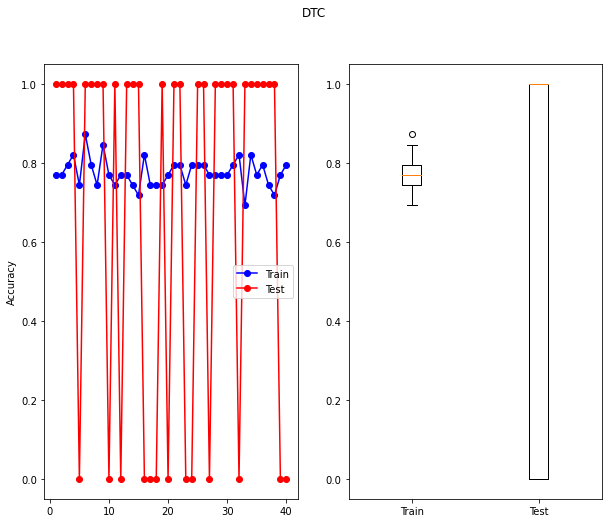

---RFC---
Average Accuracy Train: 0.985
Standard Deviation Train: 0.015
Average Accuracy Test: 0.575
Standard Deviation Test: 0.494




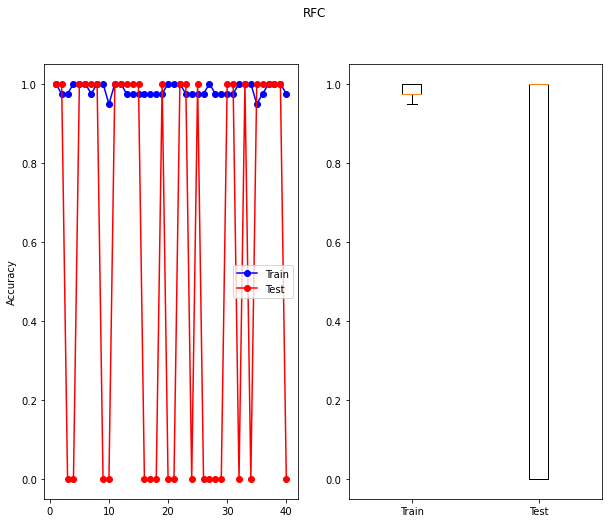

---GBT---
Average Accuracy Train: 1.0
Standard Deviation Train: 0.0
Average Accuracy Test: 0.625
Standard Deviation Test: 0.484




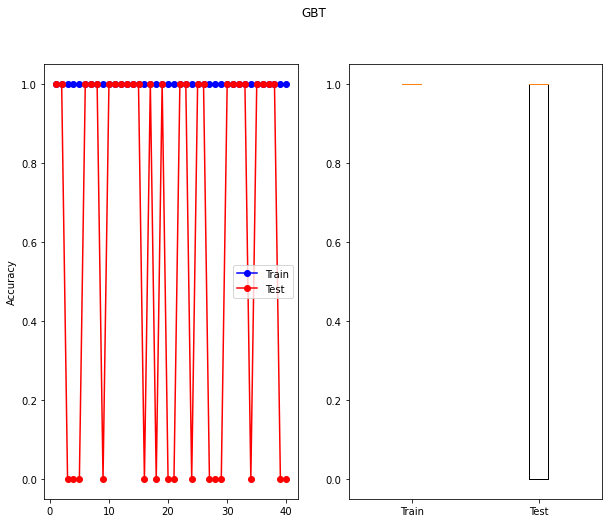

---MLP---
Average Accuracy Train: 0.983
Standard Deviation Train: 0.022
Average Accuracy Test: 0.625
Standard Deviation Test: 0.484




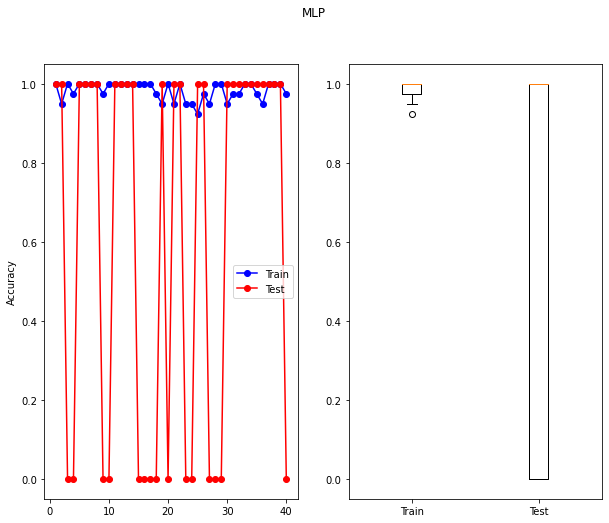

---SMV---
Average Accuracy Train: 0.834
Standard Deviation Train: 0.022
Average Accuracy Test: 0.6
Standard Deviation Test: 0.49




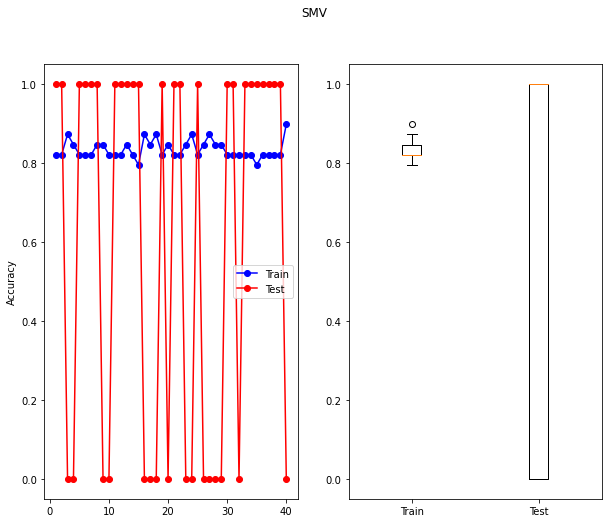

In [25]:
# Defining method for division, train and test
loo = LeaveOneOut()

# First loop to train each of the desire models
for name, model in models:
    
    print(f"---\033[1m{name.upper()}\033[0m---")
        
    # Listas para almacenar las métricas en cada iteración
    accuracy_train = []
    accuracy_test = []

    # Second loop to divide in train and test
    for i, (train_index, test_index) in enumerate(loo.split(patients)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Normalize the data when needing
        if name != 'DTC' and name != 'RFC':
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        # Training the model
        model.fit(X_train, y_train)

        # Predict for the train and test subset and compute
        y_pred_train = model.predict(X_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:,1]
        
        # Evaluate and store accuracy
        accuracy_train.append(accuracy_score(y_train, y_pred_train))
        accuracy_test.append(accuracy_score(y_test, y_pred))
        
    # Compute the mean accuracy
    average_accuracy_train = np.mean(accuracy_train)
    average_accuracy_test = np.mean(accuracy_test)

    print(f'Average Accuracy Train: {round(average_accuracy_train, 3)}')
    print(f'Standard Deviation Train: {round(np.std(accuracy_train), 3)}')
    print(f'Average Accuracy Test: {round(average_accuracy_test, 3)}')
    print(f'Standard Deviation Test: {round(np.std(accuracy_test), 3)}')
    print('\n')
    
    iteraciones = list(range(1, 41))
    
    # Plot the results of the metrics with respect each iteration
    fig, axs = plt.subplots(1, 2, figsize=(10, 8))
    
    axs[0].plot(iteraciones, accuracy_train, marker='o', linestyle='-', color='b', label='Train')
    axs[0].plot(iteraciones, accuracy_test, marker='o', linestyle='-', color='r', label='Test')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    
    axs[1].boxplot([accuracy_train, accuracy_test], labels=['Train', 'Test'])
    
    fig.suptitle(name)
    plt.show()